In [1]:
import sys, os
import torch
import numpy as np
import utils
from torch.nn import Module, Parameter
import torch.optim as opt
from utils import preprocess
# from umap import UMAP
from sklearn.decomposition import PCA

In [123]:
class cfrmModel(Module):
    def __init__(self, dir, N=3, batch_size=100, lr=1e-3, dropout=0.1):
        super().__init__()
        self.batch_size = batch_size
        self.alpha = torch.FloatTensor([1, 1, 1, 1, 10])
        self.dropout = dropout
        # data
        counts_rna = np.loadtxt(os.path.join(dir, 'GxC1.txt')).T
        counts_atac = np.loadtxt(os.path.join(dir, 'RxC2.txt')).T
        
        counts_rna = preprocess(counts = counts_rna, mode = "quantile", modality = "RNA")
        counts_atac = preprocess(counts = counts_atac, mode = "quantile", modality= "ATAC")

        self.G = torch.FloatTensor(counts_rna)
        self.R = torch.FloatTensor(counts_atac)
        self.A = torch.FloatTensor(np.loadtxt(os.path.join(dir, 'RxG.txt')))
        assert self.A.shape[0] == self.R.shape[1]
        assert self.A.shape[1] == self.G.shape[1]
        self.label_g = torch.LongTensor(np.loadtxt(os.path.join(dir, 'gene_label.txt')))
        self.label_c1 = torch.LongTensor(np.loadtxt(os.path.join(dir, 'cell_label_C1.txt'), skiprows=1, usecols=[1]))
        self.label_c2 = torch.LongTensor(np.loadtxt(os.path.join(dir, 'cell_label_C2.txt'), skiprows=1, usecols=[1]))

        # learnable parameters
        self.D_gr = Parameter(torch.ones(N, 1))
        u_g, s_g, v_g = torch.svd(self.G)
        self.C_1 = Parameter(u_g[:, :N])
        self.C_g = Parameter(v_g[:, :N])
        self.A_1g = self.C_1.t() @ self.G @ self.C_g
        u_r, s_r, v_r = torch.svd(self.R)
        self.C_2 = Parameter(u_r[:, :N])
        self.C_r = Parameter(v_r[:, :N])
        self.A_2r = self.C_2.t() @ self.R @ self.C_r
        self.D_12 = torch.eye(N)
        loss = self.batch_loss('valid')
        for l in loss:
            print(l.item())
        # optimizer
        self.optimizer = opt.Adam(self.parameters(), lr=lr)

    @staticmethod
    def orthogonal_loss(A):
        return (A.t() @ A - torch.eye(A.shape[1])).pow(2).sum()

    def batch_loss(self, mode='C_c'):
        if mode == 'C_c':
            loss1 = (self.G - self.C_1 @ self.A_1g.detach() @ self.C_g.detach().t()).pow(2).mean()
            loss2 = (self.R - self.C_2 @ self.A_2r.detach() @ self.C_r.detach().t()).pow(2).mean()
            loss5 = sum(map(self.orthogonal_loss, [self.C_1, self.C_2]))
            loss3, loss4 = 0, 0
        elif mode == 'C_r':
            loss2 = (self.R - self.C_2.detach() @ self.A_2r.detach() @ self.C_r.t()).pow(2).mean()
            loss3 = (self.A - self.C_r @ (self.D_gr.detach() * self.C_g.detach().t())).pow(2).mean()
            loss5 = sum(map(self.orthogonal_loss, [self.C_r]))
            loss1, loss4 = 0, 0
        elif mode == 'C_g':
            loss1 = (self.G - self.C_1.detach() @ self.A_1g.detach() @ self.C_g.t()).pow(2).mean()
            loss3 = (self.A - self.C_r.detach() @ (self.D_gr.detach() * self.C_g.t())).pow(2).mean()
            loss5 = sum(map(self.orthogonal_loss, [self.C_g]))
            loss2, loss4 = 0, 0
        elif mode == 'valid':
            with torch.no_grad():
                loss1 = (self.G - self.C_1 @ self.A_1g @ self.C_g.t()).pow(2).mean()
                loss2 = (self.R - self.C_2 @ self.A_2r @ self.C_r.t()).pow(2).mean()
                loss3 = (self.A - self.C_r @ (self.D_gr * self.C_g.t())).pow(2).mean()
                loss4 = (self.A_1g - self.D_12 * self.A_2r).pow(2).mean()
                loss5 = sum(map(self.orthogonal_loss, [self.C_1, self.C_2, self.C_g, self.C_r]))
        loss = self.alpha[0] * loss1 + self.alpha[1] * loss2 + self.alpha[2] * loss3 + self.alpha[3] * loss4 + \
               self.alpha[4] * loss5
        # loss1 = (self.G - self.C_1 @ self.A_1g @ self.C_g.t()).pow(2).sum()
        # loss2 = (self.R - self.C_2 @ self.A_2r @ self.C_r.t()).pow(2).sum()
        # loss3 = (self.A - self.C_r @ (self.D_gr * self.C_g.t())).pow(2).sum()
        # loss4 = (self.A_1g - self.D_12 * self.A_2r).pow(2).mean()
        # loss5 = sum(map(self.orthogonal_loss, [self.C_1, self.C_2, self.C_g, self.C_r]))
        return loss, self.alpha[0] * loss1, self.alpha[1] * loss2, self.alpha[2] * loss3, self.alpha[3] * loss4, \
               self.alpha[4] * loss5

    def train_func(self, T):
        best_loss = 1e12
        count = 0
        for t in range(T):
            self.optimizer.zero_grad()
            for mode in ['C_c']:
            # for mode in ['C_c', 'C_r', 'C_g']:
                loss, loss1, loss2, loss3, loss4, loss5 = self.batch_loss(mode)
                loss.backward()
                self.optimizer.step()
            self.A_1g = self.C_1.t() @ self.G @ self.C_g
            self.A_2r = self.C_2.t() @ self.R @ self.C_r
            self.D_12 = torch.diag((self.A_1g * self.A_2r).sum(dim=1) / self.A_2r.pow(2).sum(dim=1)).detach()
            
            loss, loss1, loss2, loss3, loss4, loss5 = self.batch_loss('valid')
            print('Epoch {}, Training Loss: {:.4f}'.format(t+1, loss.item()))
            info = [
                'loss RNA: {:.5f}'.format(loss1.item()),
                'loss ATAC: {:.5f}'.format(loss2.item()),
                'loss gene act: {:.5f}'.format(loss3.item()),
                'loss merge: {:.5f}'.format(loss4.item()),
                'loss ortho: {:.5f}'.format(loss5.item()),
            ]
            for i in info:
                print("\t", i)
            if loss.item() < best_loss:
                best_loss = loss.item()
                count = 0
            else:
                count += 1
                if count % 20 == 0:
                    self.optimizer.param_groups[0]['lr'] *= 0.5
                    print('Epoch: {}, shrink lr to {:.4f}'.format(t+1, self.optimizer.param_groups[0]['lr']))
                    if self.optimizer.param_groups[0]['lr'] < 1e-4:
                        break
                    else:
                        count = 0
                    


In [142]:
model = cfrmModel(dir = '../data/simulated/2batches_3clusts', N=3, dropout=0)
model.train_func(T=100000)

157575.6875
0.2241944968700409
0.04583536460995674
0.00041880420758388937
157575.421875
1.3905042395290224e-10
Epoch 1, Training Loss: 28.3084
	 loss RNA: 0.22507
	 loss ATAC: 0.04621
	 loss gene act: 0.00042
	 loss merge: 27.78328
	 loss ortho: 0.25338
Epoch 2, Training Loss: 11.3868
	 loss RNA: 0.22550
	 loss ATAC: 0.04587
	 loss gene act: 0.00042
	 loss merge: 11.08179
	 loss ortho: 0.03327
Epoch 3, Training Loss: 10.6630
	 loss RNA: 0.22464
	 loss ATAC: 0.04593
	 loss gene act: 0.00042
	 loss merge: 10.33304
	 loss ortho: 0.05895
Epoch 4, Training Loss: 47.3148
	 loss RNA: 0.22496
	 loss ATAC: 0.04606
	 loss gene act: 0.00042
	 loss merge: 46.89683
	 loss ortho: 0.14651
Epoch 5, Training Loss: 70.0962
	 loss RNA: 0.22533
	 loss ATAC: 0.04599
	 loss gene act: 0.00042
	 loss merge: 69.71448
	 loss ortho: 0.10995
Epoch 6, Training Loss: 62.0362
	 loss RNA: 0.22476
	 loss ATAC: 0.04587
	 loss gene act: 0.00042
	 loss merge: 61.73600
	 loss ortho: 0.02915
Epoch 7, Training Loss: 39.4772

Epoch 57, Training Loss: 34.7854
	 loss RNA: 0.22421
	 loss ATAC: 0.04585
	 loss gene act: 0.00042
	 loss merge: 34.51472
	 loss ortho: 0.00022
Epoch 58, Training Loss: 34.6591
	 loss RNA: 0.22421
	 loss ATAC: 0.04585
	 loss gene act: 0.00042
	 loss merge: 34.38846
	 loss ortho: 0.00012
Epoch 59, Training Loss: 34.3936
	 loss RNA: 0.22421
	 loss ATAC: 0.04585
	 loss gene act: 0.00042
	 loss merge: 34.12307
	 loss ortho: 0.00004
Epoch 60, Training Loss: 34.0341
	 loss RNA: 0.22420
	 loss ATAC: 0.04585
	 loss gene act: 0.00042
	 loss merge: 33.76365
	 loss ortho: 0.00001
Epoch 61, Training Loss: 33.6383
	 loss RNA: 0.22420
	 loss ATAC: 0.04585
	 loss gene act: 0.00042
	 loss merge: 33.36784
	 loss ortho: 0.00002
Epoch 62, Training Loss: 33.2702
	 loss RNA: 0.22420
	 loss ATAC: 0.04585
	 loss gene act: 0.00042
	 loss merge: 32.99967
	 loss ortho: 0.00006
Epoch 63, Training Loss: 32.9919
	 loss RNA: 0.22420
	 loss ATAC: 0.04585
	 loss gene act: 0.00042
	 loss merge: 32.72128
	 loss ortho: 

None
None


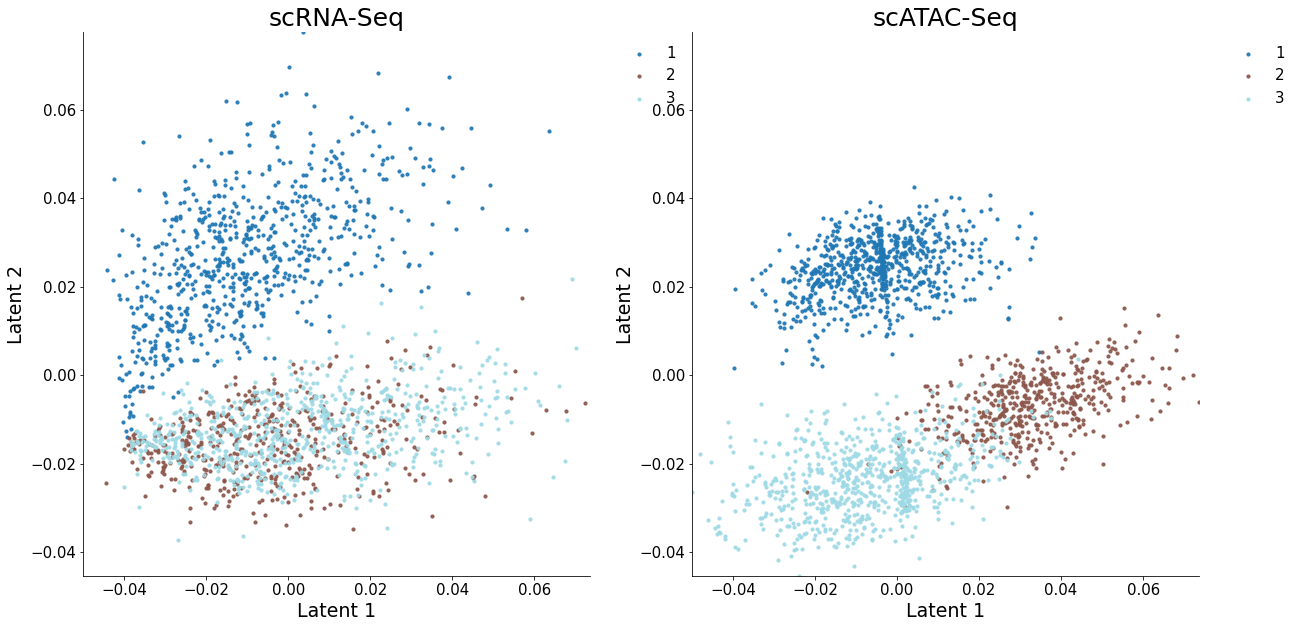

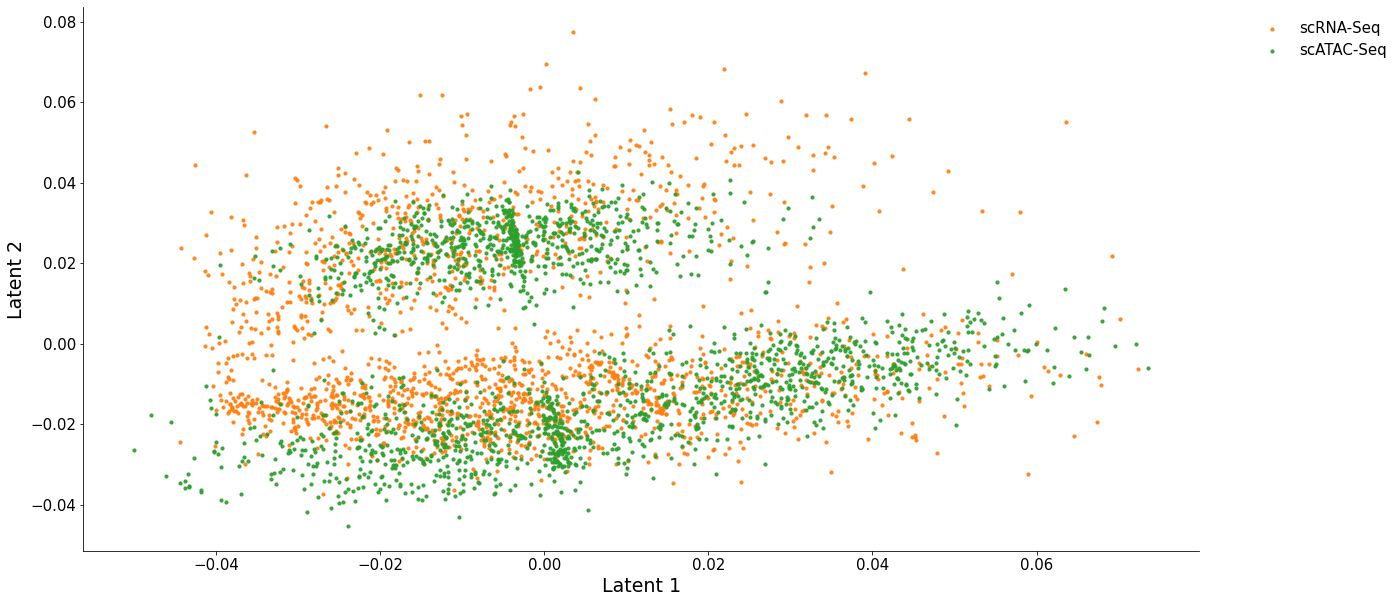

In [143]:
pca_op = PCA(n_components = 2)
z_rna = model.C_1.detach().numpy()
z_atac = model.C_2.detach().numpy()
z = pca_op.fit_transform(np.concatenate((z_rna, z_atac), axis = 0))
z_rna = z[:z_rna.shape[0],:]
z_atac = z[z_rna.shape[0]:,:]

label_rna = [x for x in model.label_c1.numpy()]
label_atac = [x for x in model.label_c2.numpy()]
label_rna = model.label_c1.numpy()[:,None]
label_atac = model.label_c2.numpy()[:,None]

utils.plot_latent(z_rna, z_atac, label_rna, label_atac, mode= "separate", save = None)
utils.plot_latent(z_rna, z_atac, label_rna, label_atac, mode= "modality", save = None)

157575.6875
0.2241944968700409
0.04583536460995674
0.00041880420758388937
157575.421875
1.3905042395290224e-10
None
None


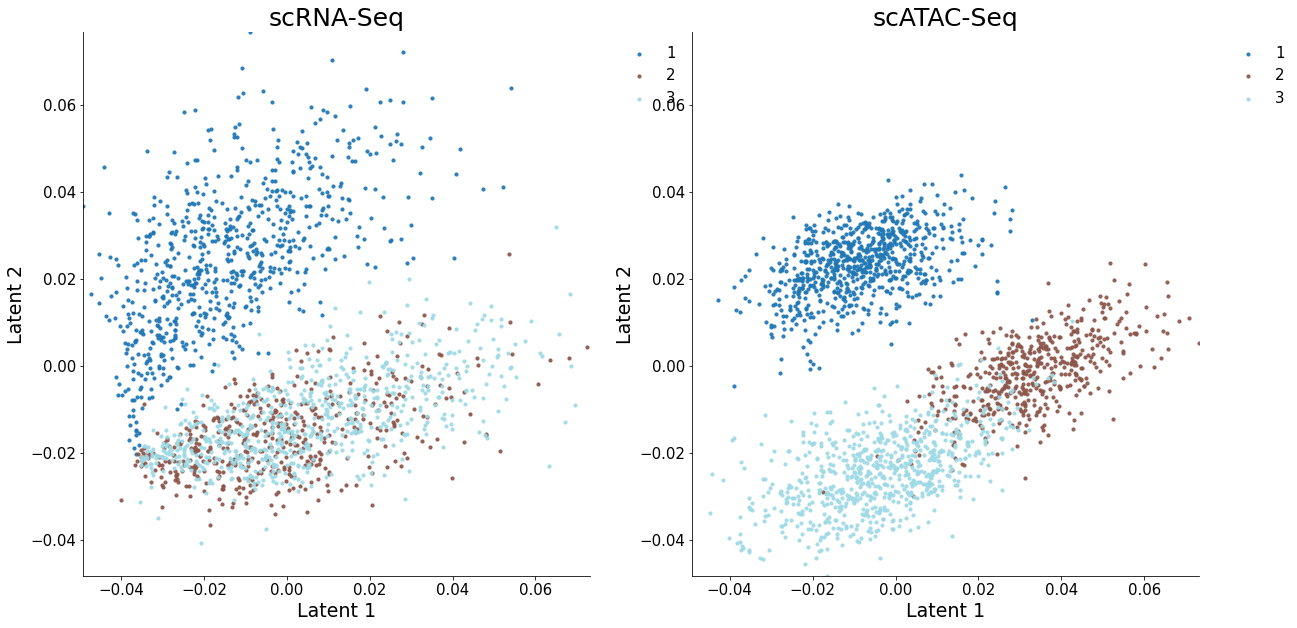

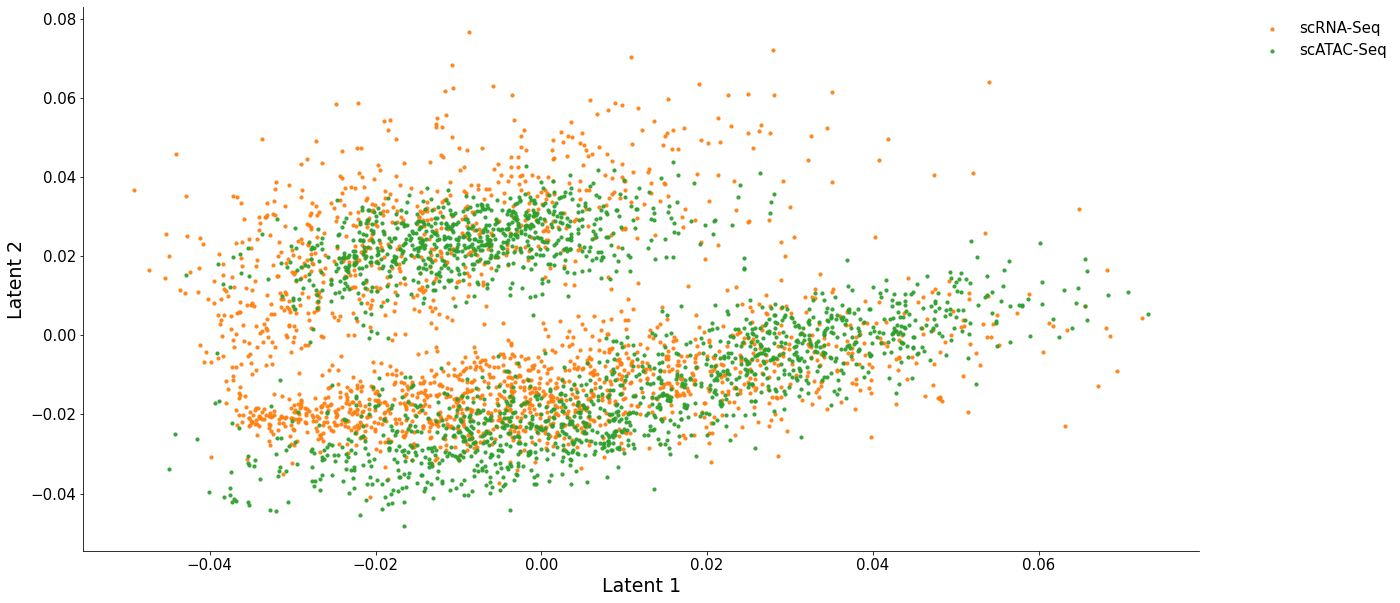

In [145]:
model = cfrmModel(dir = '../data/simulated/2batches_3clusts', N=3, dropout=0)
pca_op = PCA(n_components = 2)
z_rna = model.C_1.detach().numpy()
z_atac = model.C_2.detach().numpy()
z = pca_op.fit_transform(np.concatenate((z_rna, z_atac), axis = 0))
z_rna = z[:z_rna.shape[0],:]
z_atac = z[z_rna.shape[0]:,:]

label_rna = [x for x in model.label_c1.numpy()]
label_atac = [x for x in model.label_c2.numpy()]
label_rna = model.label_c1.numpy()[:,None]
label_atac = model.label_c2.numpy()[:,None]

utils.plot_latent(z_rna, z_atac, label_rna, label_atac, mode= "separate", save = None)
utils.plot_latent(z_rna, z_atac, label_rna, label_atac, mode= "modality", save = None)

In [146]:
model = cfrmModel(dir = '../data/simulated/2batches_6clusts', N=6, dropout=0)
model.train_func(T=100000)

48438.33984375
0.18992415070533752
0.04276727885007858
0.0004193283384665847
48438.10546875
2.334816229243586e-10
Epoch 1, Training Loss: 8.2499
	 loss RNA: 0.19670
	 loss ATAC: 0.04314
	 loss gene act: 0.00042
	 loss merge: 7.36312
	 loss ortho: 0.64652
Epoch 2, Training Loss: 1.7213
	 loss RNA: 0.19032
	 loss ATAC: 0.04281
	 loss gene act: 0.00042
	 loss merge: 1.44389
	 loss ortho: 0.04383
Epoch 3, Training Loss: 5.3227
	 loss RNA: 0.19138
	 loss ATAC: 0.04286
	 loss gene act: 0.00042
	 loss merge: 4.93573
	 loss ortho: 0.15233
Epoch 4, Training Loss: 6.1957
	 loss RNA: 0.19375
	 loss ATAC: 0.04298
	 loss gene act: 0.00042
	 loss merge: 5.58826
	 loss ortho: 0.37024
Epoch 5, Training Loss: 4.3697
	 loss RNA: 0.19310
	 loss ATAC: 0.04293
	 loss gene act: 0.00042
	 loss merge: 3.86084
	 loss ortho: 0.27237
Epoch 6, Training Loss: 2.2827
	 loss RNA: 0.19112
	 loss ATAC: 0.04282
	 loss gene act: 0.00042
	 loss merge: 1.96731
	 loss ortho: 0.08104
Epoch 7, Training Loss: 1.1240
	 loss RN

Epoch 58, Training Loss: 1.1924
	 loss RNA: 0.19000
	 loss ATAC: 0.04278
	 loss gene act: 0.00042
	 loss merge: 0.95861
	 loss ortho: 0.00061
Epoch 59, Training Loss: 1.1762
	 loss RNA: 0.18999
	 loss ATAC: 0.04278
	 loss gene act: 0.00042
	 loss merge: 0.94257
	 loss ortho: 0.00047
Epoch 60, Training Loss: 1.1585
	 loss RNA: 0.18999
	 loss ATAC: 0.04278
	 loss gene act: 0.00042
	 loss merge: 0.92497
	 loss ortho: 0.00031
Epoch 61, Training Loss: 1.1418
	 loss RNA: 0.18999
	 loss ATAC: 0.04278
	 loss gene act: 0.00042
	 loss merge: 0.90843
	 loss ortho: 0.00017
Epoch 62, Training Loss: 1.1277
	 loss RNA: 0.18999
	 loss ATAC: 0.04278
	 loss gene act: 0.00042
	 loss merge: 0.89440
	 loss ortho: 0.00009
Epoch 63, Training Loss: 1.1164
	 loss RNA: 0.18999
	 loss ATAC: 0.04278
	 loss gene act: 0.00042
	 loss merge: 0.88317
	 loss ortho: 0.00008
Epoch 64, Training Loss: 1.1074
	 loss RNA: 0.18999
	 loss ATAC: 0.04278
	 loss gene act: 0.00042
	 loss merge: 0.87411
	 loss ortho: 0.00011
Epoch 

None
None


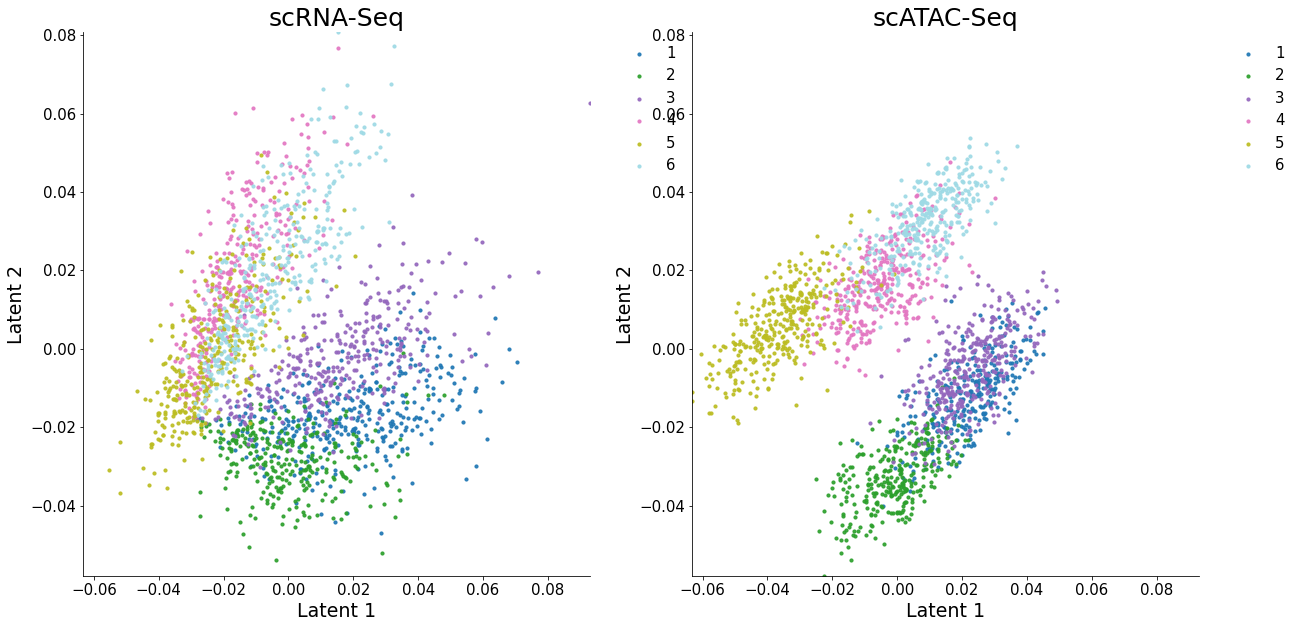

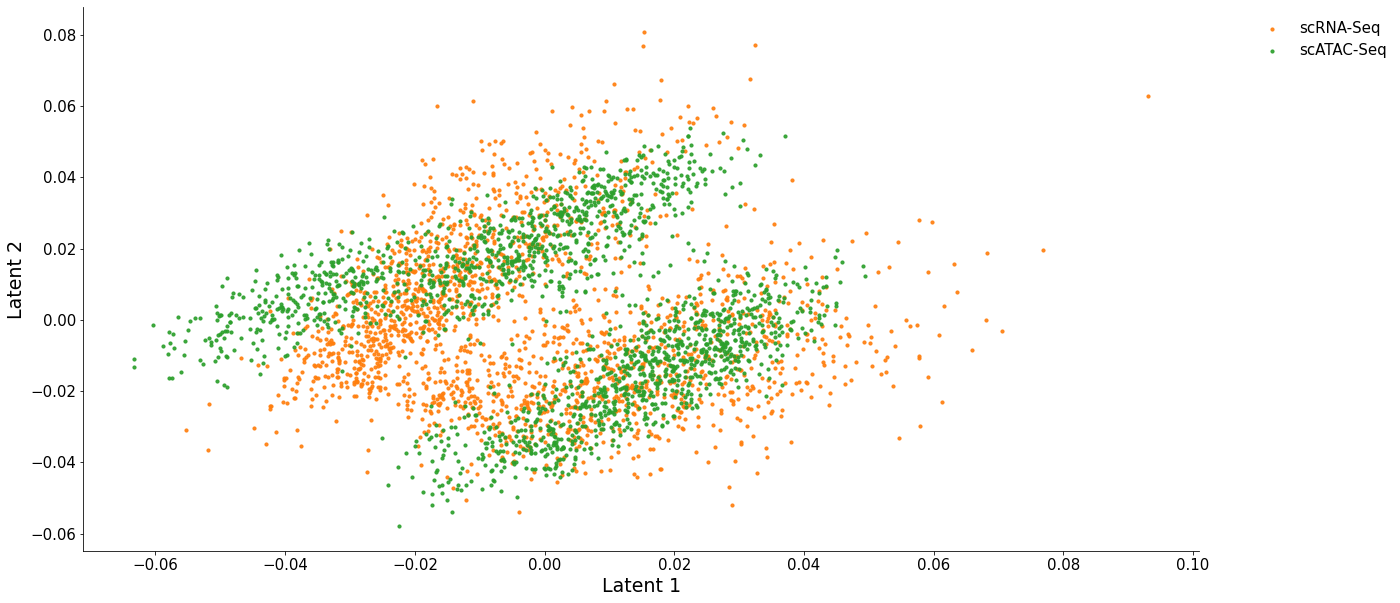

In [147]:
pca_op = PCA(n_components = 2)
z_rna = model.C_1.detach().numpy()
z_atac = model.C_2.detach().numpy()
z = pca_op.fit_transform(np.concatenate((z_rna, z_atac), axis = 0))
z_rna = z[:z_rna.shape[0],:]
z_atac = z[z_rna.shape[0]:,:]

label_rna = [x for x in model.label_c1.numpy()]
label_atac = [x for x in model.label_c2.numpy()]
label_rna = model.label_c1.numpy()[:,None]
label_atac = model.label_c2.numpy()[:,None]

utils.plot_latent(z_rna, z_atac, label_rna, label_atac, mode= "separate", save = None)
utils.plot_latent(z_rna, z_atac, label_rna, label_atac, mode= "modality", save = None)

In [149]:
class cfrmModel(Module):
    def __init__(self, dir, N=3, batch_size=100, lr=1e-3, dropout=0.1):
        super().__init__()
        self.batch_size = batch_size
        self.alpha = torch.FloatTensor([1, 1, 1, 1, 10])
        self.dropout = dropout
        # data
        counts_rna = np.loadtxt(os.path.join(dir, 'GxC1.txt')).T
        counts_atac = np.loadtxt(os.path.join(dir, 'RxC2.txt')).T
        
        counts_rna = preprocess(counts = counts_rna, mode = "quantile", modality = "RNA")
        counts_atac = preprocess(counts = counts_atac, mode = "quantile", modality= "ATAC")

        self.G = torch.FloatTensor(counts_rna)
        self.R = torch.FloatTensor(counts_atac)
        self.A = torch.FloatTensor(np.loadtxt(os.path.join(dir, 'RxG.txt')))
        assert self.A.shape[0] == self.R.shape[1]
        assert self.A.shape[1] == self.G.shape[1]
        self.label_g = torch.LongTensor(np.loadtxt(os.path.join(dir, 'gene_label.txt')))
        self.label_c1 = torch.LongTensor(np.loadtxt(os.path.join(dir, 'cell_label_C1.txt'), skiprows=1, usecols=[1]))
        self.label_c2 = torch.LongTensor(np.loadtxt(os.path.join(dir, 'cell_label_C2.txt'), skiprows=1, usecols=[1]))

        # learnable parameters
        self.D_gr = Parameter(torch.ones(N, 1))
        u_g, s_g, v_g = torch.svd(self.G)
        self.C_1 = Parameter(u_g[:, :N])
        self.C_g = Parameter(v_g[:, :N])
        self.A_1g = self.C_1.t() @ self.G @ self.C_g
        u_r, s_r, v_r = torch.svd(self.R)
        self.C_2 = Parameter(u_r[:, :N])
        self.C_r = Parameter(v_r[:, :N])
        self.A_2r = self.C_2.t() @ self.R @ self.C_r
        self.D_12 = torch.eye(N)
        loss = self.batch_loss('valid')
        for l in loss:
            print(l.item())
        # optimizer
        self.optimizer = opt.Adam(self.parameters(), lr=lr)

    @staticmethod
    def orthogonal_loss(A):
        return (A.t() @ A - torch.eye(A.shape[1])).pow(2).sum()

    def batch_loss(self, mode='C_c'):
        if mode == 'C_c':
            loss1 = (self.G - self.C_1 @ self.A_1g.detach() @ self.C_g.detach().t()).pow(2).mean()
            loss2 = (self.R - self.C_2 @ self.A_2r.detach() @ self.C_r.detach().t()).pow(2).mean()
            loss5 = sum(map(self.orthogonal_loss, [self.C_1, self.C_2]))
            loss3, loss4 = 0, 0
        elif mode == 'C_r':
            loss2 = (self.R - self.C_2.detach() @ self.A_2r.detach() @ self.C_r.t()).pow(2).mean()
            loss3 = (self.A - self.C_r @ (self.D_gr.detach() * self.C_g.detach().t())).pow(2).mean()
            loss5 = sum(map(self.orthogonal_loss, [self.C_r]))
            loss1, loss4 = 0, 0
        elif mode == 'C_g':
            loss1 = (self.G - self.C_1.detach() @ self.A_1g.detach() @ self.C_g.t()).pow(2).mean()
            loss3 = (self.A - self.C_r.detach() @ (self.D_gr.detach() * self.C_g.t())).pow(2).mean()
            loss5 = sum(map(self.orthogonal_loss, [self.C_g]))
            loss2, loss4 = 0, 0
        elif mode == 'valid':
            with torch.no_grad():
                loss1 = (self.G - self.C_1 @ self.A_1g @ self.C_g.t()).pow(2).mean()
                loss2 = (self.R - self.C_2 @ self.A_2r @ self.C_r.t()).pow(2).mean()
                loss3 = (self.A - self.C_r @ (self.D_gr * self.C_g.t())).pow(2).mean()
                loss4 = (self.A_1g - self.D_12 * self.A_2r).pow(2).mean()
                loss5 = sum(map(self.orthogonal_loss, [self.C_1, self.C_2, self.C_g, self.C_r]))
        loss = self.alpha[0] * loss1 + self.alpha[1] * loss2 + self.alpha[2] * loss3 + self.alpha[3] * loss4 + \
               self.alpha[4] * loss5
        # loss1 = (self.G - self.C_1 @ self.A_1g @ self.C_g.t()).pow(2).sum()
        # loss2 = (self.R - self.C_2 @ self.A_2r @ self.C_r.t()).pow(2).sum()
        # loss3 = (self.A - self.C_r @ (self.D_gr * self.C_g.t())).pow(2).sum()
        # loss4 = (self.A_1g - self.D_12 * self.A_2r).pow(2).mean()
        # loss5 = sum(map(self.orthogonal_loss, [self.C_1, self.C_2, self.C_g, self.C_r]))
        return loss, self.alpha[0] * loss1, self.alpha[1] * loss2, self.alpha[2] * loss3, self.alpha[3] * loss4, \
               self.alpha[4] * loss5

    def train_func(self, T):
        best_loss = 1e12
        count = 0
        for t in range(T):
            self.optimizer.zero_grad()
            # for mode in ['C_c']:
            for mode in ['C_c', 'C_r', 'C_g']:
                loss, loss1, loss2, loss3, loss4, loss5 = self.batch_loss(mode)
                loss.backward()
                self.optimizer.step()
            self.A_1g = self.C_1.t() @ self.G @ self.C_g
            self.A_2r = self.C_2.t() @ self.R @ self.C_r
            self.D_12 = torch.diag((self.A_1g * self.A_2r).sum(dim=1) / self.A_2r.pow(2).sum(dim=1)).detach()
            
            loss, loss1, loss2, loss3, loss4, loss5 = self.batch_loss('valid')
            print('Epoch {}, Training Loss: {:.4f}'.format(t+1, loss.item()))
            info = [
                'loss RNA: {:.5f}'.format(loss1.item()),
                'loss ATAC: {:.5f}'.format(loss2.item()),
                'loss gene act: {:.5f}'.format(loss3.item()),
                'loss merge: {:.5f}'.format(loss4.item()),
                'loss ortho: {:.5f}'.format(loss5.item()),
            ]
            for i in info:
                print("\t", i)
            if loss.item() < best_loss:
                best_loss = loss.item()
                count = 0
            else:
                count += 1
                if count % 20 == 0:
                    self.optimizer.param_groups[0]['lr'] *= 0.5
                    print('Epoch: {}, shrink lr to {:.4f}'.format(t+1, self.optimizer.param_groups[0]['lr']))
                    if self.optimizer.param_groups[0]['lr'] < 1e-4:
                        break
                    else:
                        count = 0
                    



In [150]:
model = cfrmModel(dir = '../data/simulated/2batches_6clusts', N=6, dropout=0)
model.train_func(T=100000)

48438.33984375
0.18992415070533752
0.04276727885007858
0.0004193283384665847
48438.10546875
2.334816229243586e-10
Epoch 1, Training Loss: 461.4281
	 loss RNA: 0.22051
	 loss ATAC: 0.04441
	 loss gene act: 0.00042
	 loss merge: 454.38858
	 loss ortho: 6.77420
Epoch 2, Training Loss: 1082.6224
	 loss RNA: 0.20364
	 loss ATAC: 0.04356
	 loss gene act: 0.00042
	 loss merge: 1080.80920
	 loss ortho: 1.56569
Epoch 3, Training Loss: 147.4496
	 loss RNA: 0.21410
	 loss ATAC: 0.04364
	 loss gene act: 0.00042
	 loss merge: 145.53804
	 loss ortho: 1.65342
Epoch 4, Training Loss: 107.3300
	 loss RNA: 0.21756
	 loss ATAC: 0.04426
	 loss gene act: 0.00042
	 loss merge: 102.75594
	 loss ortho: 4.31182
Epoch 5, Training Loss: 135.6738
	 loss RNA: 0.20404
	 loss ATAC: 0.04495
	 loss gene act: 0.00042
	 loss merge: 132.71608
	 loss ortho: 2.70830
Epoch 6, Training Loss: 71.3491
	 loss RNA: 0.19392
	 loss ATAC: 0.04611
	 loss gene act: 0.00042
	 loss merge: 70.36636
	 loss ortho: 0.74226
Epoch 7, Trainin

Epoch 56, Training Loss: 113.0510
	 loss RNA: 0.19091
	 loss ATAC: 0.04431
	 loss gene act: 0.00042
	 loss merge: 112.80830
	 loss ortho: 0.00704
Epoch 57, Training Loss: 111.2511
	 loss RNA: 0.19091
	 loss ATAC: 0.04430
	 loss gene act: 0.00042
	 loss merge: 111.01034
	 loss ortho: 0.00512
Epoch 58, Training Loss: 111.3535
	 loss RNA: 0.19091
	 loss ATAC: 0.04429
	 loss gene act: 0.00042
	 loss merge: 111.11477
	 loss ortho: 0.00309
Epoch 59, Training Loss: 112.5619
	 loss RNA: 0.19090
	 loss ATAC: 0.04428
	 loss gene act: 0.00042
	 loss merge: 112.32341
	 loss ortho: 0.00286
Epoch 60, Training Loss: 114.2860
	 loss RNA: 0.19089
	 loss ATAC: 0.04427
	 loss gene act: 0.00042
	 loss merge: 114.04700
	 loss ortho: 0.00347
Epoch 61, Training Loss: 116.0164
	 loss RNA: 0.19088
	 loss ATAC: 0.04426
	 loss gene act: 0.00042
	 loss merge: 115.77766
	 loss ortho: 0.00321
Epoch 62, Training Loss: 116.9346
	 loss RNA: 0.19088
	 loss ATAC: 0.04425
	 loss gene act: 0.00042
	 loss merge: 116.69687


None
None


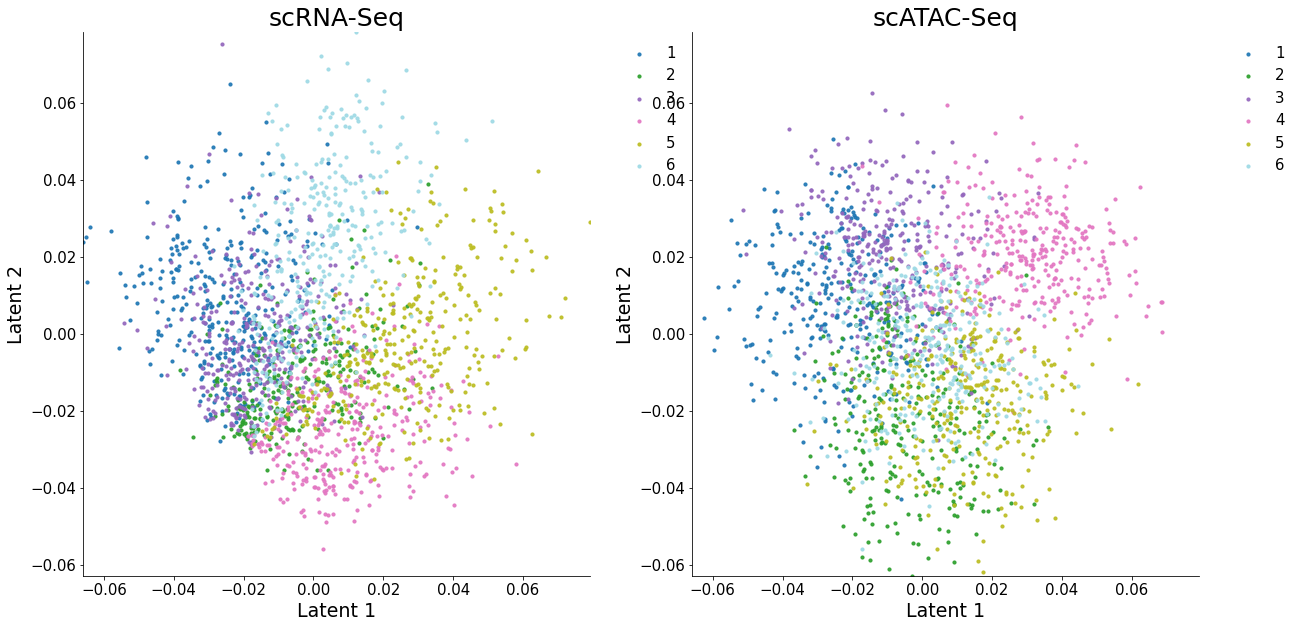

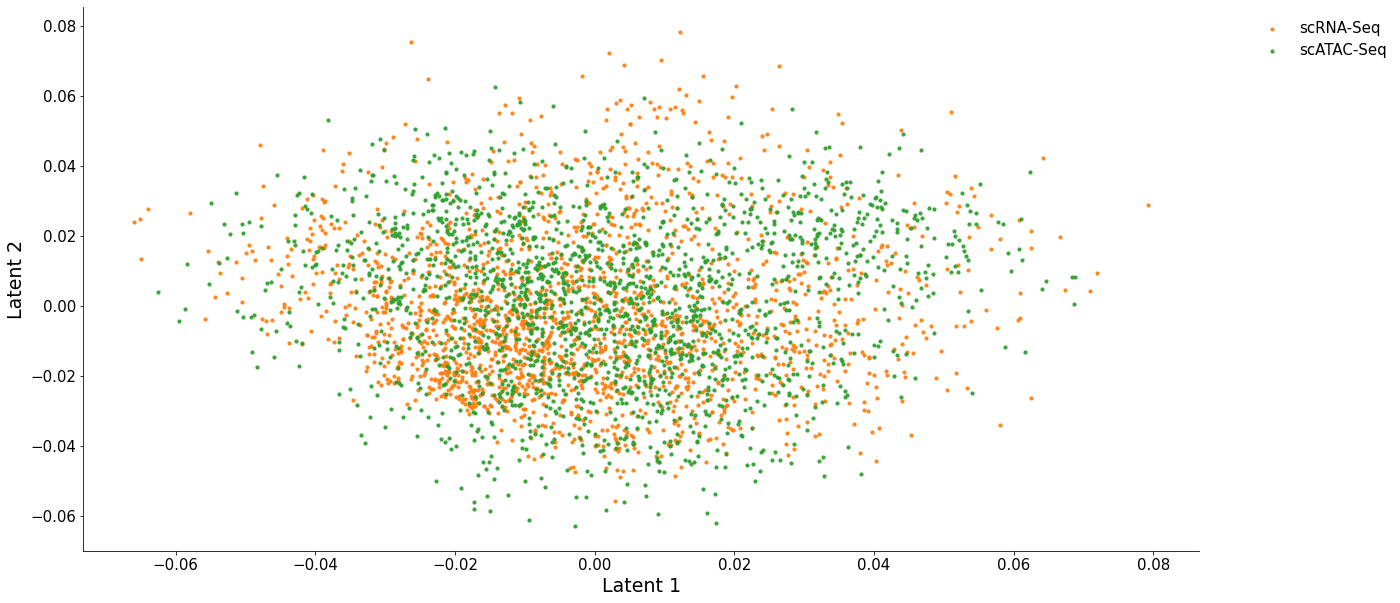

In [151]:
pca_op = PCA(n_components = 2)
z_rna = model.C_1.detach().numpy()
z_atac = model.C_2.detach().numpy()
z = pca_op.fit_transform(np.concatenate((z_rna, z_atac), axis = 0))
z_rna = z[:z_rna.shape[0],:]
z_atac = z[z_rna.shape[0]:,:]

label_rna = [x for x in model.label_c1.numpy()]
label_atac = [x for x in model.label_c2.numpy()]
label_rna = model.label_c1.numpy()[:,None]
label_atac = model.label_c2.numpy()[:,None]

utils.plot_latent(z_rna, z_atac, label_rna, label_atac, mode= "separate", save = None)
utils.plot_latent(z_rna, z_atac, label_rna, label_atac, mode= "modality", save = None)